In [33]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import re
from shutil import copy2
import cv2

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import pocketsphinx

ModuleNotFoundError: No module named 'cv2'

### Bag 0 : Trial n Error

In [5]:
def load_images_from_folder(folder):
    images = []
    filenames = []
    
    def extract_id(filename):
        match = re.search(r'id_(\d+)_', filename)
        return int(match.group(1)) if match else -1
    
    file_list = [f for f in os.listdir(folder) if f.endswith(".jpg") or f.endswith(".png")]
    file_list.sort(key=extract_id)
    
    for filename in file_list:
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert('RGB') 
        img = img.resize((128, 128))
        img_array = np.array(img)
        images.append((img_array, filename))
    
    return images

folder_path = r"C:\Users\gagah\Desktop\KKN\data\Train Images 13440x32x32\train"
images_with_filenames = load_images_from_folder(folder_path)

images = np.array([img[0] for img in images_with_filenames])
filenames = [img[1] for img in images_with_filenames]

print(f'Total data gambar: {len(images)}')
print(f'Shape setiap gambar: {images[0].shape}')

Total data gambar: 13440
Shape setiap gambar: (128, 128, 3)


In [ ]:
# Memisahkan gambar berdasarkan label
label_dict = {}
for img_array, filename in images_with_filenames:
    match = re.search(r'label_(\d+)', filename)
    if match:
        label = int(match.group(1))
        if label not in label_dict:
            label_dict[label] = []
        label_dict[label].append((img_array, filename))

# Menampilkan gambar per label
for label, images in label_dict.items():
    fig, axes = plt.subplots(1, 8, figsize=(10, 2))
    axes = axes.ravel()
    for i in range(min(8, len(images))):  # Hanya menampilkan maksimal 6 gambar per label
        axes[i].imshow(images[i][0])
        axes[i].axis('off')
        axes[i].set_title(images[i][1], fontsize=8)
    plt.suptitle(f'Label {label}')
    plt.tight_layout()
    plt.show()

In [7]:
def create_folders_by_label(source_folder, destination_folder):
    # Membuat folder tujuan jika belum ada
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    file_list = [f for f in os.listdir(source_folder) if f.endswith(".jpg") or f.endswith(".png")]
    
    for filename in file_list:
        match = re.search(r'id_(\d+)_label_(\d+)', filename)
        if match:
            img_id = match.group(1)
            label = match.group(2)
            
            # Membuat path folder label
            label_folder = os.path.join(destination_folder, f'lab_{label}')
            if not os.path.exists(label_folder):
                os.makedirs(label_folder)
            
            # Menyalin file ke folder tujuan dengan nama file baru
            src_path = os.path.join(source_folder, filename)
            dest_path = os.path.join(label_folder, f'id_{img_id}.png')
            copy2(src_path, dest_path)

source_folder_path = r"C:\Users\gagah\Desktop\KKN\data\Train Images 13440x32x32\train"
destination_folder_path = r"C:\Users\gagah\Desktop\KKN\data\Data_Train_Images"

create_folders_by_label(source_folder_path, destination_folder_path)


### Bag 1 : Classification Hijaiyah

In [15]:
TRAINING_DIR = destination_folder_path

model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=2,
    shear_range=0.4, 
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training' 
)

validation_generator = datagen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(42, activation='relu'),
    tf.keras.layers.Dense(28, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'model_{epoch:02d}_{val_accuracy:.2f}.h5'),  # Nama file dengan epoch dan akurasi validasi
    monitor='val_accuracy',    # Metrik yang dipantau
    save_best_only=True,       # Hanya menyimpan model terbaik
    mode='max',                # Mode 'max' karena kita ingin akurasi maksimum
    verbose=1                  # Menampilkan log setiap kali model disimpan
)

model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback]
)

Found 10752 images belonging to 28 classes.
Found 2688 images belonging to 28 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        18496     
                                 

c:\Users\gagah\Desktop\KKN\.conda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


336/336 [==============================] - ETA: 0s - loss: 1.5370 - accuracy: 0.5002
Epoch 2: val_accuracy improved from 0.41592 to 0.57292, saving model to model\model_02_0.57.h5
336/336 [==============================] - 82s 243ms/step - loss: 1.5370 - accuracy: 0.5002 - val_loss: 1.3519 - val_accuracy: 0.5729
Epoch 3/50
336/336 [==============================] - ETA: 0s - loss: 1.1111 - accuracy: 0.6310
Epoch 3: val_accuracy improved from 0.57292 to 0.67485, saving model to model\model_03_0.67.h5
336/336 [==============================] - 88s 260ms/step - loss: 1.1111 - accuracy: 0.6310 - val_loss: 0.9827 - val_accuracy: 0.6749
Epoch 4/50
336/336 [==============================] - ETA: 0s - loss: 0.8829 - accuracy: 0.7096
Epoch 4: val_accuracy improved from 0.67485 to 0.70871, saving model to model\model_04_0.71.h5
336/336 [==============================] - 84s 251ms/step - loss: 0.8829 - accuracy: 0.7096 - val_loss: 0.8977 - val_accuracy: 0.7087
Epoch 5/50
336/336 [================

420/420 [==============================] - 62s 146ms/step


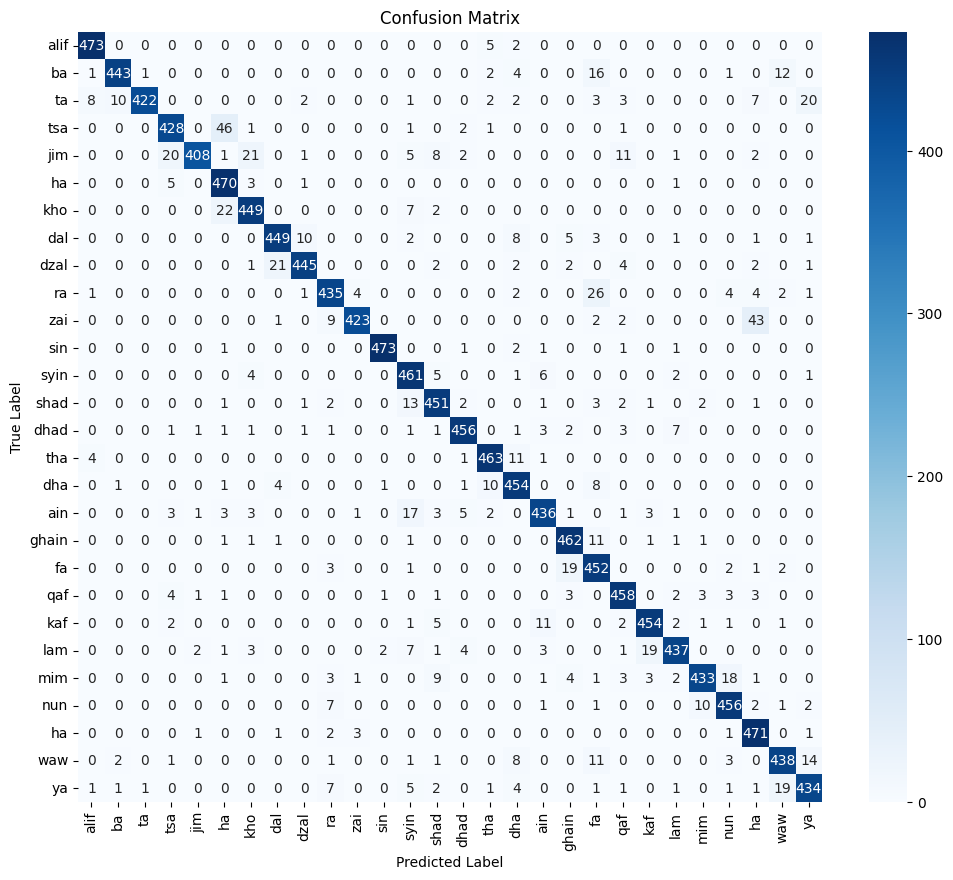

              precision    recall  f1-score   support

        alif       0.97      0.99      0.98       480
          ba       0.97      0.92      0.95       480
          ta       1.00      0.88      0.93       480
         tsa       0.92      0.89      0.91       480
         jim       0.99      0.85      0.91       480
          ha       0.85      0.98      0.91       480
         kho       0.92      0.94      0.93       480
         dal       0.94      0.94      0.94       480
        dzal       0.96      0.93      0.94       480
          ra       0.93      0.91      0.92       480
         zai       0.98      0.88      0.93       480
         sin       0.99      0.99      0.99       480
        syin       0.88      0.96      0.92       480
        shad       0.92      0.94      0.93       480
        dhad       0.96      0.95      0.96       480
         tha       0.95      0.96      0.96       480
         dha       0.91      0.95      0.93       480
         ain       0.94    

In [32]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def load_images_from_folders(base_folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(base_folder))
    
    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(base_folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                if filename.endswith(".png"):
                    img_path = os.path.join(class_folder, filename)
                    img_array = load_and_preprocess_image(img_path)
                    images.append(img_array)
                    labels.append(class_index)
    
    images = np.vstack(images)  # Combine all images into one large array
    labels = np.array(labels)
    return images, labels, class_names

# Load the model
model = load_model('model/model_38_0.86.h5')

# Path to the dataset folder
base_folder = 'data/Data_Train_Images'

# Load and preprocess images
images, true_labels, class_names = load_images_from_folders(base_folder)

# Predict the class
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Mapping from original class names to new labels
label_mapping = {
    'lab_1': 'alif',
    'lab_2': 'ba',
    'lab_3': 'ta',
    'lab_4': 'tsa',
    'lab_5': 'jim',
    'lab_6': 'ha',
    'lab_7': 'kho',
    'lab_8': 'dal',
    'lab_9': 'dzal',
    'lab_10': 'ra',
    'lab_11': 'zai',
    'lab_12': 'sin',
    'lab_13': 'syin',
    'lab_14': 'shad',
    'lab_15': 'dhad',
    'lab_16': 'tha',
    'lab_17': 'dha',
    'lab_18': 'ain',
    'lab_19': 'ghain',
    'lab_20': 'fa',
    'lab_21': 'qaf',
    'lab_22': 'kaf',
    'lab_23': 'lam',
    'lab_24': 'mim',
    'lab_25': 'nun',
    'lab_26': 'ha',
    'lab_27': 'waw',
    'lab_28': 'ya'
}

# Ensure the class names are in the desired order
class_names_sorted = sorted(class_names, key=lambda x: int(x.split('_')[1]))
new_labels_sorted = [label_mapping[label] for label in class_names_sorted]

# Display confusion matrix with new labels
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=new_labels_sorted, yticklabels=new_labels_sorted)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report with new labels
print(classification_report(true_labels, predicted_classes, target_names=new_labels_sorted))


### Bag 2 : Recognize Doa Speech